In [1]:
import numpy as np
import pandas as pd
import random
from keras.models import Model, load_model, model_from_json
from keras.layers import Input, Conv1D, BatchNormalization, add, Activation, MaxPooling1D, UpSampling1D
from keras.layers import AveragePooling1D, Concatenate, Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from os import listdir

Using TensorFlow backend.
/home/luke/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/luke/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/luke/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/luke/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [ ]:
DATA_PATH = './alldata'
SUM_PATH = './summary.txt'
files = listdir(DATA_PATH)
files.sort()
files

In [ ]:
def getData():
    data = dict()
    files = listdir(DATA_PATH)
    files.sort()
    for file in files:
        path = DATA_PATH + '/' + file
        mat = loadmat(path)  # load mat-file
        mdata = mat['EEG']  # variable in mat file
        mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
        # * SciPy reads in structures as structured NumPy arrays of dtype object
        # * The size of the array is the size of the structure array, not the number
        #   elements in any particular field. The shape defaults to 2-dimensional.
        # * For convenience make a dictionary of the data using the names from dtypes
        # * Since the structure has only one element, but is 2-D, index it at [0, 0]
        ndata = {n: mdata[n][0, 0] for n in mdtype.names}
        length = ndata['data'].shape[1]
        print(file, ndata['data'].shape[0])
        data[path] = length
    return data
data = getData()
data

In [ ]:
fhandle = open(SUM_PATH, 'w')
for key in data:
    fhandle.write(key + ' ' + str(data[key]) + '\n')
fhandle.close()

In [3]:
trainParts = [1,2,3,4,5,6,7,8,9,10]
testPart = trainParts.pop(np.random.randint(0,9))
test = np.random.choice(trainParts, 9, replace=True)
print(trainParts, testPart, test)

[1, 2, 4, 5, 6, 7, 8, 9, 10] 3 [ 7  7 10  8  7  8 10  6  7]


In [ ]:
def readData(FPATH):
    fhandle = open(FPATH, 'r')
    dat = dict()
    for line in fhandle:
        words = line.split()
        dat[words[0]] = int(words[1])
    return dat
data = readData(SUM_PATH)
data

In [4]:
def getFrame(fname):
    mat = loadmat(fname)  # load mat-file
    mdata = mat['EEG']  # variable in mat file
    mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
    # * SciPy reads in structures as structured NumPy arrays of dtype object
    # * The size of the array is the size of the structure array, not the number
    #   elements in any particular field. The shape defaults to 2-dimensional.
    # * For convenience make a dictionary of the data using the names from dtypes
    # * Since the structure has only one element, but is 2-D, index it at [0, 0]
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    
    #create dataframe dictionary
    cols = dict()
    curr = 0
    for chan in range(128):
        string = "chan" + str(curr)
        cols[string] = ndata['data'][curr]
        curr += 1
    df=pd.DataFrame(cols)
    
    #rescale from 0 - 512
    maxes = df.apply(np.max)
    mins = df.apply(np.min)
    for n in range(len(maxes)):
        maxes[n] = maxes[n] - mins[n]
        df[maxes.index[n]] = (df[maxes.index[n]] - mins[n])/maxes[n]*511
    df = df.astype(int)
    return df

df = getFrame('./alldata/L02_level_100.mat')
maxes = df.apply(np.max)
mins = df.apply(np.min)
print(maxes, mins)

chan0      511
chan1      511
chan2      511
chan3      511
chan4      511
          ... 
chan123    511
chan124    511
chan125    511
chan126    511
chan127    511
Length: 128, dtype: int64 chan0      0
chan1      0
chan2      0
chan3      0
chan4      0
          ..
chan123    0
chan124    0
chan125    0
chan126    0
chan127    0
Length: 128, dtype: int64


In [5]:
def getClass(number, allClasses):
    if allClasses:
        return number % 9
    elif number < 2:
        return 0
    elif number < 4:
        return 1
    return 2

def makeValArrays(data, allClasses):
    keyList = list(data.keys())
    arrayChunks = []
    for n in range(len(keyList)):
        print(keyList[n])
        df = getFrame(keyList[n])
        for chunk in data[keyList[n]]:
            cf = df[chunk[0]:chunk[1]].copy()
            if allClasses:
                classes = 9
            else:
                classes = 3
            target = np.zeros((classes))
            num = getClass(n, allClasses)
            target[num] = 1
            arrayChunks.append([np.array(cf), target])
    random.shuffle(arrayChunks)
    X, Y = zip(*arrayChunks)
    X = np.array(X)
    Y = np.array(Y)
    print(X.shape, Y.shape)
    return (X, Y)

def getPart(number):
    if number < 10:
        return '0' + str(number) + '_'
    else:
        return str(number) + '_'

In [12]:
DEF_LR = .01
DEF_LR_DEC = .01
POOLS = [8,6,4,2]
STEPS = 384
NUM_CLASSES = 9
FILT_FACTOR = 1
KERNEL_SIZE = 7
DILATION = 4
EPOCHS = 30
C0 = 'decline_075'
C1 = 'decline_selfpaced'
C2 = 'incline_075'
C3 = 'incline_selfpaced'
C4 = 'level_050'
C5 = 'level_075'
C6 = 'level_100'
C7 = 'level_125'
C8 = 'level_selfpaced'
DATA_PATH = './alldata'
SUM_PATH = './summary.txt'

class ConvNetwork:
    
    def __init__(self, batches=45, alpha = DEF_LR, alpha_dec = DEF_LR_DEC, pools = POOLS, steps = STEPS,
                filts = NUM_CLASSES, kernel=KERNEL_SIZE, dilation = DILATION,
                factor = FILT_FACTOR, splitAll = True, allClasses=True, single = False, p=0,
                softmax = True, epochs = EPOCHS, saveAs = "best_model.h5"):
        self.batchSize = batches
        self.channels = 128
        self.steps = steps
        self.pools = pools
        self.alpha = alpha
        if allClasses:
            self.filters = filts
        else:
            self.filters = filts//3
        self.kSize = kernel
        self.dRate = dilation
        self.alpha_decay = alpha_dec
        self.trainAll = splitAll
        self.fact = factor
        self.trainParts = list(range(1,11))
        self.allClasses = allClasses
        self.single = single
        self.participant = p
        self.epochs = epochs
        if softmax:
            self.act = 'softmax'
        else:
            self.act = 'relu'
        self.mpath = saveAs
        self.m = self.buildModel()
        
    def TrainModel(self, data):
        if self.trainAll:
            if self.single:
                nDat = dict()
                self.train = dict()
                self.test = dict()
                for key in data:
                    tstring = './alldata/L' + getPart(self.participant)
                    if key.startswith(tstring):
                        print(data[key])
                        self.train[key] = data[key]
                        self.test[key] = data[key]
                        nDat[key] = data[key]
            else:
                self.train = data.copy()
                self.test = data.copy()
                nDat = data.copy()
            val = 24
        else:
            if(self.participant==0):
                self.testPart = self.trainParts.pop(np.random.randint(0,9))
            else:
                self.testPart = self.trainParts.pop(self.participant-1)
            self.train = dict()
            self.test = dict()
            self.minPart = 2
            print("test set: ", self.testPart)
            val = min(data.values()) // 384 // 5
            nDat = data.copy()
        self.indices = nDat.copy()
        random.seed()
        allDat = 0
        val = min(data.values()) // 384 // 5
        
        #create indices for chunks for validation and training splits
        #create dictionary for number of chunks in training set
        for key in nDat:
            total = data[key] - 750
            num = total // STEPS
            over = total % STEPS
            start = np.random.randint(0,over)
            curr = 750 + start
            chunks = []
            while curr + STEPS < total + 750:
                chunks.append([curr, curr+STEPS])
                curr += STEPS
            random.shuffle(chunks)
            if self.trainAll:
                self.train[key] = chunks[val+1:]
                self.test[key] = chunks[0:val]
                entries = len(chunks) - val - 1
                self.indices[key] = list(range(entries))
                allDat += entries
            elif key.startswith('./alldata/L' + getPart(self.testPart)):
                self.test[key] = chunks[val:(2*val)]
            else:
                self.train[key] = chunks
                entries = len(chunks)
                self.indices[key] = list(range(entries))
                allDat += entries
            
        #prepare first batch data
        self.numDat = allDat
        self.currDat = 0
        self.batch = self.indices.copy()
        self.parts = np.random.choice(self.trainParts, 9, replace=True)
        if self.single:
            for n in range(len(self.parts)):
                self.parts[n] = self.participant
        self.cnames = [C0, C1, C2, C3, C4, C5, C6, C7, C8]
        self.used = [None]*9
        self.keys = []
        self.frames = []
        for n in range(len(self.cnames)):
            part = getPart(self.parts[n])
            self.used[n] = [self.parts[n]]
            fname = DATA_PATH + '/L' + part + self.cnames[n] + '.mat'
            self.frames.append(getFrame(fname))
            self.keys.append(fname)
        
        self.X_Val, self.Y_Val = makeValArrays(self.test, self.allClasses)
        #print(self.batch)
        es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10)
        mc = ModelCheckpoint(self.mpath, monitor='val_acc', mode='max', verbose=1,
                            save_best_only=True)
        print(self.numDat, self.batchSize)
        histories = self.m.fit_generator(self.batchGenerator(), (self.numDat // self.batchSize + 1),
                                        self.epochs,
                                        validation_data = (self.X_Val, self.Y_Val),
                                        callbacks=[es,mc])
        return histories
    
    def makeArrays(self, data):
        arrayChunks = []
        for n in range(len(data)):
            #print(keyList[n])
            for chunk in data[n]:
                cf = self.frames[n][chunk[0]:chunk[1]].copy()
                target = np.zeros((self.filters))
                num = getClass(n, self.allClasses)
                target[num] = 1
                arrayChunks.append([np.array(cf), target])
        random.shuffle(arrayChunks)
        #print(arrayChunks[0][0].shape, arrayChunks[0][1].shape)
        X, Y = zip(*arrayChunks)
        #print(len(X), len(Y))
        X = np.array(X)
        Y = np.array(Y)
        #print(X.shape, Y.shape)
        return (X, Y)
    
    def batchGenerator(self):
        reset = False
        self.numBatches = 0
        while True:
            currBatch = [None]*9
            newFrames = dict()
            for n in range(len(self.cnames)):
                key = self.keys[n]
                numChunks = len(self.batch[key])
                #print(key, numChunks)
                indices = []
                #get five chunks
                if numChunks >= 5:
                    for index in np.random.randint(0,numChunks-4,5):
                        indices.append(self.batch[key].pop(index))
                    self.currDat += 5
                #or the remaining chunks and move to a different file
                else:
                    self.currDat += numChunks
                    for index in self.batch[key]:
                        indices.append(index)
                    self.batch[key] = []
                    if not self.single:
                        tries = 0
                        while self.parts[n] in self.used[n] and tries < 100:
                            self.parts[n] = np.random.choice(self.trainParts, 1)
                            tries += 1
                        if tries > 100:
                            reset = True
                            print("\nTries triggered")
                        self.used[n].append(self.parts[n])
                        self.keys[n] = DATA_PATH + '/L' + getPart(self.parts[n]) + self.cnames[n] + '.mat'
                        newFrames[n] = self.keys[n]
                    
                #make data chunks for batch
                chunks = []
                for index in indices:
                    if index < len(self.train[key]):
                        chunks.append(self.train[key][index].copy())
                currBatch[n] = chunks
            
            #make batch
            #print(currBatch)
            batch_x, batch_y = self.makeArrays(currBatch)
            self.numBatches += 1
            
            #book keeping for new batch or new frames
            for key in newFrames:
                self.frames[key] = getFrame(newFrames[key])
                
            if reset or self.currDat >= (self.numDat - 2) or self.numBatches >= ((self.numDat
                                                                                 //self.batchSize) + 1):
                print("Resetting", self.currDat, self.numDat,
                      self.numBatches, (self.numDat // self.batchSize +1) )
                for key in self.train:
                    entries = len(self.train[key])
                    self.batch[key] = list(range(entries))
                self.parts = np.random.choice(self.trainParts, 9, replace=True)
                if self.single:
                    for n in range(len(self.parts)):
                        self.parts[n] = self.participant
                print(self.parts)
                for n in range(len(self.cnames)):
                    part = getPart(self.parts[n])
                    self.used[n] = [self.parts[n]]
                    fname = DATA_PATH + '/L' + part + self.cnames[n] + '.mat'
                    self.frames[n] = getFrame(fname)
                    self.keys[n] = fname
                reset = False
                self.currDat = 0
                self.numBatches = 0
            yield(batch_x,batch_y)

    def buildModel(self):
        data = Input(shape=(self.steps, self.channels))
        featureMaps = []
        #Build Encoder
        pconv1 = Conv1D(self.fact*self.filters, self.kSize, padding='same',
                        activation = 'relu', dilation_rate=self.dRate)(data)
        pbn1 = BatchNormalization()(pconv1)
        pconv2 = Conv1D(self.fact*self.filters, self.kSize, padding='same',
                        activation = 'relu', dilation_rate=self.dRate)(pbn1)
        pbn2 = BatchNormalization()(pconv2)
        featureMaps.append(pbn2)
        lastIter = MaxPooling1D(self.pools[0])(pbn2)
        for i in range(1,len(self.pools)):
            conv1 = Conv1D(self.fact*self.filters, self.kSize, padding='same',
                           activation = 'relu', dilation_rate=self.dRate)(lastIter)
            bn1 = BatchNormalization()(conv1)
            conv2 = Conv1D(self.fact*self.filters, self.kSize, padding='same',
                           activation = 'relu', dilation_rate=self.dRate)(bn1)
            bn2 = BatchNormalization()(conv2)
            featureMaps.append(bn2)
            lastIter = MaxPooling1D(pool_size = self.pools[i])(bn2)
            
        #Intermediate Convolutions:
        post1 = Conv1D(self.fact*self.filters, self.kSize, padding='same',
                       activation = 'relu', dilation_rate=self.dRate)(lastIter)
        postbn1 = BatchNormalization()(post1)
        post2 = Conv1D(self.fact*self.filters, self.kSize, padding='same',
                       activation = 'relu', dilation_rate=self.dRate)(postbn1)
        lastIter = BatchNormalization()(post2)
        
        #Build Decoder:
        for i in range(len(self.pools)):
            ups = UpSampling1D(size=self.pools[3-i])(lastIter)
            c1 = Conv1D(self.fact*self.filters, self.kSize, padding='same',
                        activation = 'relu', dilation_rate=self.dRate)(ups)
            b1 = BatchNormalization()(c1)
            conc = Concatenate()([b1, featureMaps[3-i]])
            c2 = Conv1D(self.fact*self.filters, self.kSize, padding='same',
                        activation = 'relu', dilation_rate=self.dRate)(conc)
            b2 = BatchNormalization()(c2)
            c3 = Conv1D(self.fact*self.filters, self.kSize, padding='same',
                        activation = 'relu', dilation_rate=self.dRate)(b2)
            lastIter = BatchNormalization()(c3)
        
        #Classifier:
        segment = AveragePooling1D(pool_size=self.steps, strides=self.steps)(lastIter)
        output = Conv1D(self.filters, 1, activation=self.act, padding='same')(segment)
        output = Flatten()(output)
        model = Model(inputs=data, outputs=output)
        model.compile(optimizer="Adam", loss='categorical_crossentropy',
                      metrics=['acc'])
        return model

In [ ]:
CN = ConvNetwork(dilation = 2, factor = 5)
histories = CN.TrainModel(readData(SUM_PATH))

In [14]:
allAccs = []
for n in range(1,11):
    mpath = "./models/loo" + str(n) + ".h5"
    CN = ConvNetwork(dilation = 2, factor = 5, splitAll = False, p=n, saveAs = mpath)
    histories = CN.TrainModel(readData(SUM_PATH))
    CN.m.load_weights(mpath)
    acc = np.max(histories.history['val_acc'])
    print(acc)
    allAccs.append(acc)
allAccs

test set:  1
./alldata/L01_decline_075.mat
./alldata/L01_decline_selfpaced.mat
./alldata/L01_incline_075.mat
./alldata/L01_incline_selfpaced.mat
./alldata/L01_level_050.mat
./alldata/L01_level_075.mat
./alldata/L01_level_100.mat
./alldata/L01_level_125.mat
./alldata/L01_level_selfpaced.mat
(207, 384, 128) (207, 9)
9800 45
Epoch 1/30
206/217 [===========================>..] - ETA: 6s - loss: 0.8357 - acc: 0.7827Resetting 9628 9800 218 218
[10  3  8  4  4  7  3  4  3]
217/217 [==============================] - 130s 600ms/step - loss: 0.8267 - acc: 0.7859 - val_loss: 14.3272 - val_acc: 0.1111

Epoch 00001: val_acc improved from -inf to 0.11111, saving model to ./models/loo1.h5
Epoch 2/30
207/217 [===========================>..] - ETA: 6s - loss: 0.9418 - acc: 0.7513Resetting 9622 9800 218 218
[7 9 3 7 8 2 9 2 9]
217/217 [==============================] - 132s 608ms/step - loss: 0.9368 - acc: 0.7483 - val_loss: 13.5352 - val_acc: 0.1111

Epoch 00002: val_acc did not improve from 0.11111
Ep

./alldata/L03_incline_selfpaced.mat
./alldata/L03_level_050.mat
./alldata/L03_level_075.mat
./alldata/L03_level_100.mat
./alldata/L03_level_125.mat
./alldata/L03_level_selfpaced.mat
(207, 384, 128) (207, 9)
9951 45
Epoch 1/30
220/221 [============================>.] - ETA: 0s - loss: 0.8423 - acc: 0.7733Resetting 9793 9951 222 222
[10  9  1  4  4  2  2  1  4]
221/221 [==============================] - 139s 628ms/step - loss: 0.8403 - acc: 0.7736 - val_loss: 12.6662 - val_acc: 0.1159

Epoch 00001: val_acc improved from -inf to 0.11594, saving model to ./models/loo3.h5
Epoch 2/30
221/221 [==============================] - 137s 618ms/step - loss: 0.9819 - acc: 0.7379 - val_loss: 5.5319 - val_acc: 0.1159

Epoch 00002: val_acc did not improve from 0.11594
Epoch 3/30
Resetting 9796 9951 222 222
[ 1  9  2  7  8 10  8  9  8]
221/221 [==============================] - 149s 675ms/step - loss: 0.8962 - acc: 0.7506 - val_loss: 12.7600 - val_acc: 0.0386

Epoch 00003: val_acc did not improve from 0.

/home/luke/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


221/221 [==============================] - 178s 806ms/step - loss: 0.4135 - acc: 0.8806 - val_loss: 10.1170 - val_acc: 0.1111

Epoch 00006: val_acc did not improve from 0.21739
Epoch 7/30
  4/221 [..............................] - ETA: 55s - loss: 0.1145 - acc: 1.0000Resetting 9782 9951 222 222
[8 1 5 8 5 2 5 9 9]
221/221 [==============================] - 152s 689ms/step - loss: 0.2100 - acc: 0.9434 - val_loss: 12.5234 - val_acc: 0.1111

Epoch 00007: val_acc did not improve from 0.21739
Epoch 8/30
  5/221 [..............................] - ETA: 52s - loss: 0.0360 - acc: 1.0000Resetting 9792 9951 222 222
[ 4  1  9  2  4  9 10  9  8]
221/221 [==============================] - 154s 697ms/step - loss: 0.1484 - acc: 0.9600 - val_loss: 8.1961 - val_acc: 0.1063

Epoch 00008: val_acc did not improve from 0.21739
Epoch 9/30
  6/221 [..............................] - ETA: 54s - loss: 0.0377 - acc: 1.0000Resetting 9795 9951 222 222
[ 6  4 10  7  6  6  8  6 10]
221/221 [==========================


Epoch 00016: val_acc did not improve from 0.22222
Epoch 17/30
 15/221 [=>............................] - ETA: 44s - loss: 0.0055 - acc: 1.0000Resetting 9790 9953 222 222
[ 6  8 10  5  8  5  1  6  8]
221/221 [==============================] - 132s 597ms/step - loss: 0.0247 - acc: 0.9942 - val_loss: 10.3565 - val_acc: 0.1111

Epoch 00017: val_acc did not improve from 0.22222
Epoch 18/30
 16/221 [=>............................] - ETA: 53s - loss: 0.0121 - acc: 0.9986Resetting 9795 9953 222 222
[10  1 10  6  9  7  5  6  5]


/home/luke/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


221/221 [==============================] - 242s 1s/step - loss: 0.0145 - acc: 0.9974 - val_loss: 8.5229 - val_acc: 0.1401

Epoch 00018: val_acc did not improve from 0.22222
Epoch 19/30
 16/221 [=>............................] - ETA: 52s - loss: 0.0036 - acc: 1.0000Resetting 9792 9953 222 222
[3 8 5 2 5 9 6 6 5]
221/221 [==============================] - 139s 627ms/step - loss: 0.0095 - acc: 0.9978 - val_loss: 6.4887 - val_acc: 0.3237

Epoch 00019: val_acc improved from 0.22222 to 0.32367, saving model to ./models/loo4.h5
Epoch 20/30
 17/221 [=>............................] - ETA: 3:26 - loss: 0.0046 - acc: 0.9987Resetting 9791 9953 222 222
[9 5 7 9 6 2 8 3 2]
221/221 [==============================] - 157s 710ms/step - loss: 0.0044 - acc: 0.9992 - val_loss: 12.5695 - val_acc: 0.1111

Epoch 00020: val_acc did not improve from 0.32367
Epoch 21/30
 18/221 [=>............................] - ETA: 1:21 - loss: 0.0068 - acc: 1.0000Resetting 9790 9953 222 222
[ 8  1  3  5  8  7  3  3 10]
221/2


Epoch 00013: val_acc did not improve from 0.36232
Epoch 14/30
  1/220 [..............................] - ETA: 43s - loss: 0.0493 - acc: 1.0000Resetting 9750 9932 221 221
[ 2  9  9  9  9 10  2  2  6]
220/220 [==============================] - 144s 657ms/step - loss: 0.1197 - acc: 0.9692 - val_loss: 10.2945 - val_acc: 0.1111

Epoch 00014: val_acc did not improve from 0.36232
Epoch 15/30
  2/220 [..............................] - ETA: 42s - loss: 0.1012 - acc: 0.9889Resetting 9739 9932 221 221
[10 10  4  9  9  3  3  1  2]
220/220 [==============================] - 131s 595ms/step - loss: 0.0287 - acc: 0.9942 - val_loss: 6.7586 - val_acc: 0.3333

Epoch 00015: val_acc did not improve from 0.36232
Epoch 16/30
  3/220 [..............................] - ETA: 59s - loss: 0.0350 - acc: 0.9924 Resetting 9746 9932 221 221
[9 4 8 8 1 7 6 7 3]
220/220 [==============================] - 147s 667ms/step - loss: 0.0193 - acc: 0.9966 - val_loss: 8.8182 - val_acc: 0.1111

Epoch 00016: val_acc did not im

./alldata/L07_incline_075.mat
./alldata/L07_incline_selfpaced.mat
./alldata/L07_level_050.mat
./alldata/L07_level_075.mat
./alldata/L07_level_100.mat
./alldata/L07_level_125.mat
./alldata/L07_level_selfpaced.mat
(207, 384, 128) (207, 9)
9956 45
Epoch 1/30
219/221 [============================>.] - ETA: 1s - loss: 0.9661 - acc: 0.7545Resetting 9795 9956 222 222
[1 3 6 6 1 8 6 4 1]
221/221 [==============================] - 160s 724ms/step - loss: 0.9628 - acc: 0.7556 - val_loss: 10.3963 - val_acc: 0.1787

Epoch 00001: val_acc improved from -inf to 0.17874, saving model to ./models/loo7.h5
Epoch 2/30
219/221 [============================>.] - ETA: 1s - loss: 1.1409 - acc: 0.6887esetting 9800 9956 222 222
[2 3 3 9 1 6 5 4 8]
221/221 [==============================] - 126s 569ms/step - loss: 1.1328 - acc: 0.6916 - val_loss: 4.0945 - val_acc: 0.1884

Epoch 00002: val_acc improved from 0.17874 to 0.18841, saving model to ./models/loo7.h5
Epoch 3/30
219/221 [============================>.] -


Epoch 00001: val_acc improved from -inf to 0.11111, saving model to ./models/loo8.h5
Epoch 2/30
221/221 [==============================] - 128s 578ms/step - loss: 1.0615 - acc: 0.7102 - val_loss: 7.7887 - val_acc: 0.1111

Epoch 00002: val_acc did not improve from 0.11111
Epoch 3/30
  1/221 [..............................] - ETA: 54s - loss: 0.2690 - acc: 0.8889Resetting 9786 9953 222 222
[ 7  4  1  3  1  7  7  4 10]
221/221 [==============================] - 134s 605ms/step - loss: 0.7859 - acc: 0.7900 - val_loss: 12.6749 - val_acc: 0.1111

Epoch 00003: val_acc did not improve from 0.11111
Epoch 4/30
  2/221 [..............................] - ETA: 41s - loss: 0.2394 - acc: 1.0000Resetting 9787 9953 222 222
[ 1  2  3  7  6 10  7  1  7]
221/221 [==============================] - 142s 645ms/step - loss: 0.3949 - acc: 0.8906 - val_loss: 8.5646 - val_acc: 0.1111

Epoch 00004: val_acc did not improve from 0.11111
Epoch 5/30
  3/221 [..............................] - ETA: 41s - loss: 0.1094 

/home/luke/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


221/221 [==============================] - 156s 707ms/step - loss: 0.2848 - acc: 0.9165 - val_loss: 12.2305 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not improve from 0.11111
Epoch 6/30
  3/221 [..............................] - ETA: 47s - loss: 0.0377 - acc: 1.0000Resetting 9786 9953 222 222
[ 1  6  2 10  2  2  7  1  6]
221/221 [==============================] - 274s 1s/step - loss: 0.1531 - acc: 0.9615 - val_loss: 6.6759 - val_acc: 0.1111

Epoch 00006: val_acc did not improve from 0.11111
Epoch 7/30
  4/221 [..............................] - ETA: 52s - loss: 0.0285 - acc: 1.0000Resetting 9781 9953 222 222
[ 1  3  5  4  2  9  5 10  4]
221/221 [==============================] - 146s 662ms/step - loss: 0.0557 - acc: 0.9862 - val_loss: 7.2622 - val_acc: 0.1111

Epoch 00007: val_acc did not improve from 0.11111
Epoch 8/30
  5/221 [..............................] - ETA: 52s - loss: 0.0077 - acc: 1.0000Resetting 9786 9953 222 222
[7 7 3 1 9 7 5 5 2]
221/221 [==========================

/home/luke/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


220/220 [==============================] - 178s 810ms/step - loss: 0.0069 - acc: 0.9986 - val_loss: 10.8562 - val_acc: 0.1111

Epoch 00017: val_acc did not improve from 0.29952
Epoch 18/30
  4/220 [..............................] - ETA: 46s - loss: 0.0034 - acc: 1.0000Resetting 9745 9931 221 221
[1 2 3 2 6 7 3 2 8]
220/220 [==============================] - 139s 633ms/step - loss: 0.0050 - acc: 0.9995 - val_loss: 5.3988 - val_acc: 0.2222

Epoch 00018: val_acc did not improve from 0.29952
Epoch 19/30
  5/220 [..............................] - ETA: 41s - loss: 0.0026 - acc: 1.0000Resetting 9750 9931 221 221
[ 5 10  2  2  3 10  6  2  7]
220/220 [==============================] - 129s 586ms/step - loss: 0.0025 - acc: 0.9996 - val_loss: 8.4761 - val_acc: 0.1111

Epoch 00019: val_acc did not improve from 0.29952
Epoch 20/30
  6/220 [..............................] - ETA: 2:08 - loss: 0.0037 - acc: 1.0000Resetting 9741 9931 221 221
[ 4 10  4  5  5  8  8  3  8]
220/220 [=======================

[0.1111111119389534,
 0.14492753148078918,
 0.21739129722118378,
 0.32367148995399475,
 0.36231884360313416,
 0.2222222238779068,
 0.3333333432674408,
 0.1111111119389534,
 0.2995169162750244,
 0.2222222238779068]

In [15]:
print(allAccs)
print(np.mean(allAccs))

[0.1111111119389534, 0.14492753148078918, 0.21739129722118378, 0.32367148995399475, 0.36231884360313416, 0.2222222238779068, 0.3333333432674408, 0.1111111119389534, 0.2995169162750244, 0.2222222238779068]
0.23478260934352874


In [16]:
from sklearn.metrics import confusion_matrix
preds = np.argmax(CN.m.predict(CN.X_Val), axis=-1)
print(confusion_matrix(preds, np.argmax(CN.Y_Val, axis=-1)))

[[ 0  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0]
 [12  0 22  0 23  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0 23  0 23  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0 23 23 23]
 [11  0  0  0  0  0  0  0  0]]


In [26]:
mList = list(range(len(models)))
mList.pop(4)
preds = getPredictions(mList, CN.X_Val)
X = CN.X_Val
Y = CN.Y_Val
print(confusion_matrix(np.argmax(preds, axis=-1), np.argmax(CN.Y_Val, axis=-1)))

getting ./m1
getting ./m2
getting ./m3
getting ./m4
getting ./m6
getting ./m7
getting ./m8
getting ./m9
getting ./m10
[[23  0 23 18  5  0  0 23  0]
 [ 0  3  0  5  0  0  2  0  0]
 [ 0 17  0  0 18  0 12  0 22]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 23  0  0  1]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


In [29]:
CN = ConvNetwork(dilation = 2, factor = 5)
CN.m.load_weights("best_model.h5")
preds = np.argmax(CN.m.predict(X), axis=-1)
print(confusion_matrix(preds, np.argmax(Y, axis=-1)))

[[23  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  0]
 [ 0  0  0  0  0 23  0  0  0]
 [ 0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0  0 23  0]
 [ 0  0  0  0  0  0  0  0 23]]


In [17]:
#results of previous experiments
looaccs = [0.1111111119389534,
 0.14492753148078918,
 0.21739129722118378,
 0.32367148995399475,
 0.36231884360313416,
 0.2222222238779068,
 0.3333333432674408,
 0.1111111119389534,
 0.2995169162750244,
 0.2222222238779068]
accs = [0.004830917874396135,
 0.07246376811594203,
 0.20772946859903382,
 0.12077294685990338,
 0.1111111111111111,
 0.028985507246376812,
 0.1111111111111111,
 0.10628019323671498,
 0.10628019323671498,
 0.10144927536231885]
ens = [0.077468599033816,
 0.1111111111111111,
 0.1111111111111111,
 0.13526570048309178,
 0.1111111111111111,
 0.07246376811594203,
 0.1111111111111111,
 0.1111111111111111,
 0.0,
 0.15942028985507245]
raw = [.94831,
       .83816,
       .82609,
       .9995,
       .74251,
       .99903,
       .99952,
       .9256,
       .9985,
       .9729,]
rand = [1.0,
 0.8695651888847351,
 0.8019323945045471,
 1.0,
 0.772946834564209,
 0.9951691031455994,
 1.0,
 0.6135265827178955,
 1.0,
 1.0]
means = [np.mean(looaccs), np.mean(accs), np.mean(ens), np.mean(raw), np.mean(rand)]
means

[0.23478260934352874,
 0.09710144927536232,
 0.1000173913043478,
 0.925012,
 0.9053140103816986]

<IPython.core.display.Javascript object>


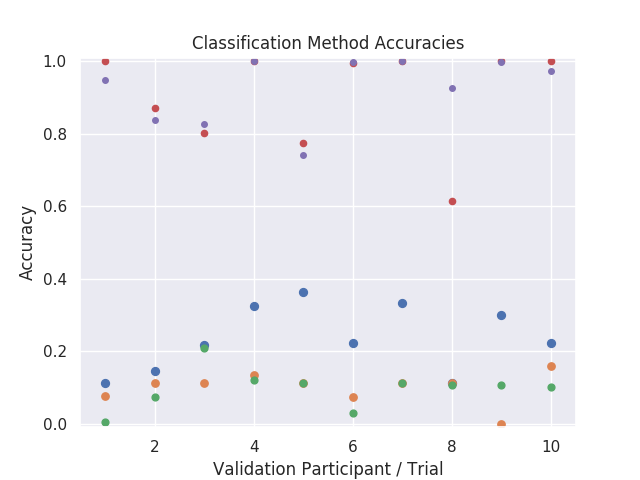

In [20]:
%matplotlib notebook
sns.set()
plt.figure()
mean = np.mean(accs)
plt.scatter(list(range(1,11)), looaccs, s=32, label="LOO Validation Accuracies: 23.4%")
plt.scatter(list(range(1,11)), ens, s=28, label="Weighted Ensemble Validation Accuracies: 10.0%")
plt.scatter(list(range(1,11)), accs, s=24, label="Unweighted Ensemble Validation Accuracies: 9.7%")
plt.scatter(list(range(1,11)), rand, s=20, label="All participants, Random Test: 90.5%")
plt.scatter(list(range(1,11)), raw, s=16, label="All participants, Validation Set: 92.5%")
plt.ylim(-.01,1.01)
plt.xlabel("Validation Participant / Trial")
plt.ylabel("Accuracy")
plt.title("Classification Method Accuracies")
plt.show()

In [ ]:
models = []
for participant in range(1,11):
    CN = ConvNetwork(dilation = 4, factor = 5, splitAll = True, single = True,
                    p = participant)
    histories = CN.TrainModel(readData(SUM_PATH))
    models.append([histories.history, CN.X_Val, CN.Y_Val])
    weight_path = "./m" + str(participant) + "model.h5"
    CN.m.save_weights(weight_path)
mod = ConvNetwork(dilation = 4, factor = 5, splitAll = True, single = True,
                 softmax=False)
model_json = mod.m.to_json()
jsonPath = "./model.json"
with open(jsonPath, "w") as json_file:
    json_file.write(model_json)

In [17]:
models[0][1]['val_acc']

[0.3333333432674408,
 0.1111111119389534,
 0.2222222238779068,
 0.3478260934352875,
 0.5555555820465088,
 0.6473429799079895,
 0.7777777910232544,
 0.7777777910232544,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

<IPython.core.display.Javascript object>


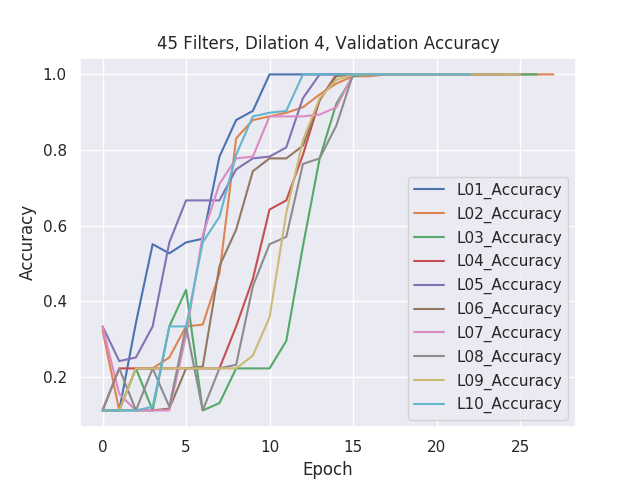

In [11]:
%matplotlib notebook
sns.set()
plt.figure()
part = 1
for pair in models:
    plt.plot(list(range(len(pair[0]['val_acc']))), pair[0]['val_acc'], label = 'L' + getPart(part) + "Accuracy")
    part += 1
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("45 Filters, Dilation 4, Validation Accuracy")
plt.show()

In [ ]:
plt.figure()
plt.plot(list(range(EPOCHS)), histories.history['val_acc'], label = 'Validation Accuracy')
plt.plot(list(range(EPOCHS)), histories.history['acc'], label = 'Training Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("45 Filters, Dilation 4")
plt.show()

In [ ]:
drates = [1,2,4]
facts = [5,10]
allDat = [True, False]
histories = dict()
for dr in drates:
    dkey = "d" + str(dr) +"_"
    for fact in facts:
        fkey = "filts*" + str(fact)
        CN = ConvNetwork(dilation = dr, factor = fact, trnall = True, allClasses = True)
        hist = CN.TrainModel(readData(SUM_PATH))
        avgAcc = np.average(hist.history['val_acc'][-5:])
        avgLss = np.average(hist.history['val_loss'][-5:])
        histories[fkey + dkey] = [avgAcc, avgLss]

In [17]:
def getPredictions(models, X):
    preds = np.zeros((X.shape[0], 9))
    CN = ConvNetwork(dilation = 4, factor = 5, splitAll = True, single = True,
                    p = participant)
    model = CN.m
    for num in models:
        print("getting ./m" + str(num+1))
        weightPath = './m' + str(num+1) + "model.h5"
        model.load_weights(weightPath)
        Y_Pred = model.predict(X)
        #a = np.argmax(Y_Pred, axis=-1)
        #b = np.zeros((a.size, 9))
        #b[np.arange(a.size), a] = 1
        preds = preds + Y_Pred
    return preds

In [45]:
m = models[9][0]
X = models[9][2]
pred = m.predict(X)
pred = np.argmax(pred, axis=-1)
pred

array([4, 2, 3, 6, 7, 2, 1, 3, 1, 0, 6, 1, 0, 0, 3, 1, 3, 2, 1, 5, 5, 2,
       7, 3, 1, 7, 4, 4, 4, 2, 0, 7, 1, 5, 0, 5, 5, 8, 8, 4, 7, 5, 1, 5,
       1, 3, 0, 8, 1, 2, 5, 6, 1, 2, 2, 7, 0, 5, 4, 3, 0, 8, 1, 2, 4, 3,
       6, 3, 6, 0, 8, 3, 6, 3, 7, 2, 1, 1, 5, 5, 6, 8, 5, 3, 5, 0, 8, 6,
       7, 4, 5, 7, 0, 1, 2, 0, 3, 4, 6, 4, 8, 8, 6, 0, 5, 2, 0, 4, 3, 7,
       5, 6, 3, 7, 7, 2, 8, 7, 0, 4, 0, 7, 2, 4, 3, 8, 6, 2, 6, 1, 3, 4,
       8, 1, 8, 1, 4, 1, 1, 8, 5, 0, 0, 1, 7, 8, 2, 4, 1, 6, 7, 4, 4, 8,
       4, 6, 2, 5, 6, 7, 1, 6, 5, 2, 0, 5, 7, 8, 7, 0, 5, 8, 2, 0, 4, 7,
       3, 3, 2, 4, 0, 8, 8, 5, 3, 6, 3, 2, 0, 3, 5, 2, 6, 6, 7, 6, 8, 8,
       6, 7, 2, 3, 4, 7, 6, 8, 4])

In [60]:
p = getPredictions(models[0:8], models[9][2])
p

array([[1.17628650e+00, 1.27530686e+00, 1.50634454e+00, ...,
        2.26282211e-01, 1.06671855e-01, 8.04884680e-02],
       [6.47715977e-01, 8.74918223e-01, 3.41143884e+00, ...,
        4.89708237e-01, 2.17850744e-01, 6.12101848e-01],
       [2.91856606e+00, 3.65357657e-01, 1.04414891e+00, ...,
        2.29844890e-03, 5.06582642e-02, 1.04059778e-02],
       ...,
       [1.62139561e-02, 1.03989378e+00, 1.95055080e+00, ...,
        2.89865069e+00, 6.08547665e-02, 6.63146305e-02],
       [1.71248394e+00, 5.21269231e-01, 1.64069617e+00, ...,
        8.02006755e-01, 4.40311789e-01, 2.65351192e-01],
       [1.49643614e+00, 1.29259700e+00, 1.43430191e+00, ...,
        4.64370657e-01, 1.83337370e-01, 1.35625699e-01]])

In [61]:
p = np.argmax(p, axis=-1)
p

array([5, 2, 0, 6, 2, 2, 0, 0, 0, 2, 6, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2,
       2, 0, 0, 2, 5, 5, 5, 2, 5, 2, 0, 2, 0, 2, 2, 3, 2, 5, 2, 2, 0, 2,
       0, 0, 2, 0, 0, 2, 2, 6, 0, 2, 2, 2, 0, 2, 5, 0, 2, 3, 0, 2, 5, 0,
       6, 0, 6, 2, 3, 0, 6, 0, 2, 2, 0, 0, 2, 2, 6, 2, 2, 0, 2, 2, 0, 6,
       2, 5, 2, 2, 2, 0, 2, 2, 0, 5, 6, 5, 0, 0, 6, 2, 2, 2, 0, 5, 0, 2,
       2, 6, 0, 2, 2, 2, 3, 2, 2, 5, 2, 2, 2, 5, 0, 0, 6, 2, 6, 0, 0, 5,
       0, 0, 3, 0, 5, 0, 0, 0, 2, 2, 2, 0, 2, 3, 2, 5, 0, 6, 2, 0, 5, 0,
       5, 6, 2, 2, 6, 2, 0, 6, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 2, 2, 5, 2,
       0, 0, 2, 5, 0, 2, 0, 2, 0, 6, 0, 2, 2, 0, 2, 2, 6, 6, 2, 6, 0, 2,
       6, 2, 2, 0, 5, 2, 6, 3, 5])

In [64]:
len(p[p==pred]) / len(p)

0.24154589371980675

In [18]:
def getAccuracies(models):
    accs = []
    for n in range(len(models)):
        mList = list(range(len(models)))
        mList.pop(n)
        X = models[n][1]
        Y_T = models[n][2]
        Y_T = np.argmax(Y_T, axis=-1)
        preds = getPredictions(mList, X)
        preds = np.argmax(preds, axis=-1)
        accs.append(len(preds[preds==Y_T]) / len(preds))
        print(accs[-1])
    return accs

In [18]:
accs = getAccuracies(models)
accs

getting ./m2
getting ./m3
getting ./m4
getting ./m5
getting ./m6
getting ./m7
getting ./m8
getting ./m9
getting ./m10
0.004830917874396135
getting ./m1
getting ./m3
getting ./m4
getting ./m5
getting ./m6
getting ./m7
getting ./m8
getting ./m9
getting ./m10
0.07246376811594203
getting ./m1
getting ./m2
getting ./m4
getting ./m5
getting ./m6
getting ./m7
getting ./m8
getting ./m9
getting ./m10
0.20772946859903382
getting ./m1
getting ./m2
getting ./m3
getting ./m5
getting ./m6
getting ./m7
getting ./m8
getting ./m9
getting ./m10
0.12077294685990338
getting ./m1
getting ./m2
getting ./m3
getting ./m4
getting ./m6
getting ./m7
getting ./m8
getting ./m9
getting ./m10
0.1111111111111111
getting ./m1
getting ./m2
getting ./m3
getting ./m4
getting ./m5
getting ./m7
getting ./m8
getting ./m9
getting ./m10
0.028985507246376812
getting ./m1
getting ./m2
getting ./m3
getting ./m4
getting ./m5
getting ./m6
getting ./m8
getting ./m9
getting ./m10
0.1111111111111111
getting ./m1
getting ./m2
getting 

[0.004830917874396135,
 0.07246376811594203,
 0.20772946859903382,
 0.12077294685990338,
 0.1111111111111111,
 0.028985507246376812,
 0.1111111111111111,
 0.10628019323671498,
 0.10628019323671498,
 0.10144927536231885]

In [15]:
CN = ConvNetwork(dilation = 4, factor = 5, splitAll = True, single = True,
                    p = participant)
model = CN.m
modStats = []
for k in range(len(models)):
    weightPath = './m' + str(k+1) + 'model.h5'
    model.load_weights(weightPath)
    X = models[k][1]
    Y = models[k][2]
    proc = []
    for n in range(X.shape[2]):
        dist = []
        T = X.copy()
        for i in range(50):
            T = T.reshape((T.shape[0], T.shape[2], T.shape[1]))
            rand = np.random.randint(0,512,384)
            T[n] = rand
            T = T.reshape((T.shape[0], T.shape[2], T.shape[1]))
            hist = model.evaluate(T, Y)
            dist.append(hist[1])
        mean = np.mean(dist)
        std = np.std(dist)
        print(n, mean, std)
        proc.append([n, mean, std])
    modStats.append(proc)

207/207 [==============================] - 0s 2ms/step
0 0.999710146188736 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
1 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
2 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
3 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
4 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
5 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
6 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
7 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
8 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
9 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
10 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
11 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
12 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
13 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
14 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
15 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
16 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
17 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
18 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
19 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
20 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
21 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
22 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
23 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
24 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
25 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
26 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
27 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
28 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
29 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
30 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
31 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
32 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
33 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
34 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
35 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
36 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
37 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
38 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
39 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
40 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
41 0.9988405847549439 0.0020631945496770994
207/207 [==============================] - 0s 2ms/step
42 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
43 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
44 0.9986473488807678 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
45 0.9992270565032959 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
46 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
47 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
48 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
49 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
50 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
51 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
52 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
53 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
54 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
55 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
56 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
57 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
58 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
59 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
60 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step
61 0.9992270565032959 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
62 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
63 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
64 0.9990338206291198 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
65 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
66 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
67 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
68 0.9985507309436799 0.0022137950509814974
207/207 [==============================] - 0s 1ms/step
69 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
70 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
71 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
72 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
73 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
74 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
75 0.9990338206291198 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
76 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
77 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
78 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
79 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
80 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
81 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
82 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
83 0.9957488107681275 0.0015698556629594321
207/207 [==============================] - 0s 1ms/step
84 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
85 0.9991304385662079 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
86 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
87 0.9951691031455994 0.0


207/207 [==============================] - 0s 2ms/step
88 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
89 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
90 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
91 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
92 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
93 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
94 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
95 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
96 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
97 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
98 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
99 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
100 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
101 0.9984541130065918 0.0022534981733575666
207/207 [==============================] - 0s 2ms/step
102 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
103 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
104 0.9987439668178558 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
105 0.9990338206291198 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
106 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
107 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
108 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
109 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
110 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
111 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
112 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
113 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
114 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
115 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
116 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
117 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
118 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
119 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
120 0.9986473488807678 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
121 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
122 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
123 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
124 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
125 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
126 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
127 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
0 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
1 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
2 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
3 0.9966183722019195 0.002213795050981497


207/207 [==============================] - 0s 1ms/step
4 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
5 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
6 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step
7 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
8 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
9 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
10 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
11 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
12 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
13 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
14 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
15 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
16 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
17 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
18 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
19 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 1ms/step
20 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
21 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
22 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
23 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
24 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
25 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
26 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
27 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
28 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
29 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step
30 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
31 0.9967149901390076 0.002253498173357566
207/207 [==============================] - 0s 2ms/step
32 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
33 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
34 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
35 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
36 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
37 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
38 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
39 0.9962319004535675 0.0020011811647385708
207/207 [==============================] - 0s 2ms/step
40 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
41 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
42 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
43 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
44 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
45 0.9971980798244476 0.0023843302397508186
207/207 [==============================] - 0s 2ms/step
46 0.9957488107681275 0.0015698556629594321
207/207 [==============================] - 0s 1ms/step
47 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
48 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step
49 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
50 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
51 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
52 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
53 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
54 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
55 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
56 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
57 0.9970048439502716 0.002344851845393933
207/207 [==============================] - 0s 1ms/step
58 0.9971014618873596 0.002366646458659575
207/207 [==============================] - 0s 1ms/step
59 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
60 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
61 0.9971014618873596 0.002366646458659575
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
62 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
63 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
64 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
65 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
66 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
67 0.9971980798244476 0.0023843302397508186
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
68 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
69 0.9969082260131836 0.002318830490112305
207/207 [==============================] - 0s 2ms/step
70 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
71 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
72 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
73 0.9957488107681275 0.0015698556629594321
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
74 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
75 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
76 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
77 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
78 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
79 0.9956521928310395 0.0014492690563201905


207/207 [==============================] - 0s 2ms/step
80 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
81 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
82 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
83 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
84 0.9971980798244476 0.0023843302397508186
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
85 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
86 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
87 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
88 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
89 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
90 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
91 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 2ms/step
92 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
93 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
94 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
95 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
96 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
97 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
98 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
99 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
100 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
101 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
102 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
103 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
104 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 2ms/step
105 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
106 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
107 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
108 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
109 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
110 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
111 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
112 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
113 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
114 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
115 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
116 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
117 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
118 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
119 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
120 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
121 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
122 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
123 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
124 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
125 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
126 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
127 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
0 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
1 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
2 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
3 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
4 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
5 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
6 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
7 0.9970048439502716 0.002344851845393933
207/207 [==============================] - 0s 2ms/step
8 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
9 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
10 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
11 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
12 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
13 0.9973913156986236 0.002407706585403611
207/207 [==============================] - 0s 2ms/step
14 0.9969082260131836 0.0023188304901123045
207/207 [==============================] - 0s 2ms/step
15 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
16 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
17 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
18 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
19 0.9971980798244476 0.0023843302397508186
207/207 [==============================] - 0s 1ms/step
20 0.9975845515727997 0.0024154484272003174
207/207 [==============================] - 0s 1ms/step
21 0.9979710233211517 0.0023843302397508186
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
22 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
23 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
24 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
25 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
26 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
27 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
28 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
29 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
30 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
31 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
32 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
33 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
34 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
35 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
36 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
37 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
38 0.9976811695098877 0.0024135152948960865
207/207 [==============================] - 0s 1ms/step
39 0.9981642591953278 0.0023448518453939326
207/207 [==============================] - 0s 2ms/step
40 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 2ms/step
41 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
42 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
43 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
44 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
45 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
46 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
47 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
48 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
49 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
50 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
51 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
52 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
53 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
54 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
55 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
56 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
57 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
58 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
59 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
60 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
61 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
62 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
63 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
64 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
65 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
66 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
67 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
68 0.9971980798244476 0.0023843302397508186


207/207 [==============================] - 0s 1ms/step
69 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
70 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
71 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
72 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
73 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
74 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
75 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
76 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
77 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
78 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
79 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
80 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
81 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
82 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
83 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
84 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
85 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
86 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
87 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step
88 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
89 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
90 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
91 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
92 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
93 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
94 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
95 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
96 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
97 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
98 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
99 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
100 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
101 0.9973913156986236 0.002407706585403611
207/207 [==============================] - 0s 1ms/step
102 0.9975845515727997 0.0024154484272003174
207/207 [==============================] - 0s 1ms/step
103 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
104 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
105 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
106 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
107 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
108 0.9977777874469758 0.002407706585403611
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
109 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
110 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
111 0.9977777874469758 0.002407706585403611
207/207 [==============================] - 0s 2ms/step
112 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
113 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
114 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
115 0.9972946977615357 0.0023979941352222276
207/207 [==============================] - 0s 1ms/step
116 0.9975845515727997 0.0024154484272003174
207/207 [==============================] - 0s 1ms/step
117 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
118 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
119 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
120 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
121 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
122 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
123 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
124 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
125 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
126 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
127 0.9959420466423035 0.0017710360407851974
207/207 [==============================] - 0s 2ms/step
0 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
1 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
2 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
3 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 1ms/step
4 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
5 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
6 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
7 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
8 0.9971014618873596 0.0023666464586595748
207/207 [==============================] - 0s 2ms/step
9 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
10 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
11 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
12 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
13 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
14 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 1ms/step
15 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
16 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
17 0.9972946977615357 0.0023979941352222276
207/207 [==============================] - 0s 1ms/step
18 0.9974879336357116 0.0024135152948960865
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
19 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
20 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
21 0.9970048439502716 0.002344851845393933
207/207 [==============================] - 0s 1ms/step
22 0.9972946977615357 0.0023979941352222276
207/207 [==============================] - 0s 1ms/step
23 0.9971014618873596 0.002366646458659575
207/207 [==============================] - 0s 2ms/step
24 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
25 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
26 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
27 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
28 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
29 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
30 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
31 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
32 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 2ms/step
33 0.9969082260131836 0.0023188304901123045
207/207 [==============================] - 0s 2ms/step
34 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
35 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
36 0.9970048439502716 0.002344851845393933
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
37 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
38 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
39 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
40 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
41 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
42 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
43 0.9974879336357116 0.0024135152948960865
207/207 [==============================] - 0s 1ms/step
44 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
45 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
46 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
47 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step
48 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
49 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
50 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
51 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
52 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
53 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
54 0.9955555748939514 0.0013105894632394785


207/207 [==============================] - 0s 1ms/step
55 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
56 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
57 0.9959420466423035 0.0017710360407851974
207/207 [==============================] - 0s 1ms/step
58 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step
59 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
60 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
61 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
62 0.9961352825164795 0.0019323587417602536
207/207 [==============================] - 0s 1ms/step
63 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
64 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
65 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
66 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
67 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
68 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 2ms/step
69 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
70 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
71 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
72 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
73 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 1ms/step
74 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
75 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
76 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
77 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
78 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
79 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
80 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
81 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
82 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
83 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
84 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
85 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
86 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
87 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
88 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step
89 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
90 0.9972946977615357 0.002397994135222227
207/207 [==============================] - 0s 2ms/step
91 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
92 0.9952657210826874 0.0006763255596160889


207/207 [==============================] - 0s 2ms/step
93 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
94 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
95 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
96 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
97 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
98 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
99 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
100 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
101 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
102 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
103 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
104 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
105 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
106 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
107 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step
108 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
109 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
110 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
111 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
112 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
113 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
114 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
115 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
116 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
117 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
118 0.9969082260131836 0.002318830490112305
207/207 [==============================] - 0s 2ms/step
119 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
120 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
121 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
122 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
123 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
124 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
125 0.9957488107681275 0.0015698556629594321
207/207 [==============================] - 0s 1ms/step
126 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
127 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
0 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
1 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
2 0.9952657210826874 0.0006763255596160889


207/207 [==============================] - 0s 2ms/step
3 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
4 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
5 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
6 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 1ms/step
7 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
8 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
9 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
10 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
11 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
12 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 2ms/step
13 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
14 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
15 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
16 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
17 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
18 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
19 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 2ms/step
20 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
21 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step
22 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
23 0.9967149901390076 0.0022534981733575666
207/207 [==============================] - 0s 2ms/step
24 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
25 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 2ms/step
26 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
27 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
28 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
29 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
30 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
31 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
32 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
33 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
34 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
35 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step
36 0.9959420466423035 0.0017710360407851974
207/207 [==============================] - 0s 1ms/step
37 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
38 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
39 0.9971014618873596 0.002366646458659575
207/207 [==============================] - 0s 1ms/step
40 0.9953623390197754 0.00094665858346383


207/207 [==============================] - 0s 2ms/step
41 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
42 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 1ms/step
43 0.9959420466423035 0.0017710360407851978
207/207 [==============================] - 0s 2ms/step
44 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 2ms/step
45 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
46 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
47 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
48 0.9959420466423035 0.0017710360407851974
207/207 [==============================] - 0s 1ms/step
49 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
50 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
51 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
52 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
53 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
54 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
55 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
56 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
57 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
58 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
59 0.9967149901390076 0.0022534981733575666
207/207 [==============================] - 0s 2ms/step
60 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
61 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
62 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
63 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
64 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
65 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 2ms/step
66 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
67 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 2ms/step
68 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
69 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
70 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
71 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
72 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
73 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step
74 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
75 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
76 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
77 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
78 0.9957488107681275 0.0015698556629594326


207/207 [==============================] - 0s 1ms/step
79 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
80 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
81 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
82 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
83 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
84 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
85 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
86 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
87 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
88 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
89 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
90 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
91 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
92 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
93 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
94 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
95 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
96 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
97 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
98 0.9957488107681275 0.0015698556629594321
207/207 [==============================] - 0s 1ms/step
99 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
100 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
101 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
102 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step
103 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
104 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
105 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step
106 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
107 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
108 0.9967149901390076 0.0022534981733575666
207/207 [==============================] - 0s 2ms/step
109 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
110 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
111 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
112 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
113 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
114 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
115 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
116 0.9960386645793915 0.001855969964217049


207/207 [==============================] - 0s 2ms/step
117 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
118 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
119 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 1ms/step
120 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
121 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
122 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
123 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
124 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
125 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 2ms/step
126 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
127 0.9957488107681275 0.0015698556629594321
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
0 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 2ms/step
1 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
2 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
3 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 1ms/step
4 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
5 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
6 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
7 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
8 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
9 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
10 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
11 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
12 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 2ms/step
13 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
14 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
15 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
16 0.9971014618873596 0.0023666464586595748
207/207 [==============================] - 0s 2ms/step
17 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
18 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
19 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
20 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
21 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
22 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
23 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
24 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 1ms/step
25 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
26 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
27 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
28 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
29 0.9969082260131836 0.002318830490112305
207/207 [==============================] - 0s 2ms/step
30 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
31 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
32 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
33 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
34 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 2ms/step
35 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
36 0.9970048439502716 0.002344851845393933
207/207 [==============================] - 0s 2ms/step
37 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
38 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
39 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
40 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
41 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
42 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
43 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
44 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
45 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
46 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
47 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
48 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
49 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
50 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
51 0.9969082260131836 0.0023188304901123045
207/207 [==============================] - 0s 1ms/step
52 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
53 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
54 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
55 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
56 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
57 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
58 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
59 0.9972946977615357 0.0023979941352222276
207/207 [==============================] - 0s 1ms/step
60 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
61 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
62 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
63 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
64 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
65 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
66 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
67 0.9961352825164795 0.0019323587417602536
207/207 [==============================] - 0s 2ms/step
68 0.9966183722019195 0.0022137950509814974
207/207 [==============================] - 0s 2ms/step
69 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
70 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
71 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
72 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
73 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
74 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
75 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
76 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
77 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
78 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
79 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
80 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
81 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
82 0.9967149901390076 0.0022534981733575666
207/207 [==============================] - 0s 1ms/step
83 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
84 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
85 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
86 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
87 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
88 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
89 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
90 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
91 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
92 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
93 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
94 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
95 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step
96 0.9976811695098877 0.0024135152948960865
207/207 [==============================] - 0s 2ms/step
97 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 2ms/step
98 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 1ms/step
99 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
100 0.9971980798244476 0.0023843302397508186
207/207 [==============================] - 0s 1ms/step
101 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
102 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
103 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
104 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
105 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
106 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
107 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
108 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 2ms/step
109 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
110 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
111 0.9973913156986236 0.0024077065854036105


207/207 [==============================] - 0s 2ms/step
112 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
113 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step
114 0.9970048439502716 0.002344851845393933
207/207 [==============================] - 0s 1ms/step
115 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 1ms/step
116 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
117 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 1ms/step
118 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
119 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
120 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
121 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
122 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
123 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
124 0.9967149901390076 0.0022534981733575666
207/207 [==============================] - 0s 1ms/step
125 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
126 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
127 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
0 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
1 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
2 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
3 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
4 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
5 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
6 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
7 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
8 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
9 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
10 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
11 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
12 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
13 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
14 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
15 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
16 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
17 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
18 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
19 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
20 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
21 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
22 0.9971014618873596 0.0023666464586595748
207/207 [==============================] - 0s 2ms/step
23 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
24 0.9951691031455994 0.0


207/207 [==============================] - 0s 2ms/step
25 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 2ms/step
26 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
27 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
28 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
29 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
30 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
31 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
32 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
33 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 2ms/step
34 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
35 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
36 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 2ms/step
37 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 2ms/step
38 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
39 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
40 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
41 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
42 0.9970048439502716 0.002344851845393933
207/207 [==============================] - 0s 1ms/step
43 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
44 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
45 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
46 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
47 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
48 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
49 0.9976811695098877 0.0024135152948960865
207/207 [==============================] - 0s 1ms/step
50 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 1ms/step
51 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
52 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
53 0.9969082260131836 0.002318830490112305
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
54 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 2ms/step
55 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
56 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 1ms/step
57 0.9971980798244476 0.0023843302397508186
207/207 [==============================] - 0s 2ms/step
58 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
59 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
60 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
61 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
62 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
63 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 1ms/step
64 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
65 0.9973913156986236 0.0024077065854036105
207/207 [==============================] - 0s 1ms/step
66 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
67 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
68 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
69 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 1ms/step
70 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
71 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
72 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
73 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
74 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
75 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
76 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
77 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
78 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
79 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
80 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
81 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
82 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
83 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
84 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
85 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
86 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
87 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
88 0.9957488107681275 0.0015698556629594321
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
89 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 1ms/step
90 0.9971014618873596 0.002366646458659575
207/207 [==============================] - 0s 2ms/step
91 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
92 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
93 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
94 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
95 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
96 0.9969082260131836 0.002318830490112305
207/207 [==============================] - 0s 2ms/step
97 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
98 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
99 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
100 0.9967149901390076 0.0022534981733575666
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
101 0.9971014618873596 0.002366646458659575
207/207 [==============================] - 0s 1ms/step
102 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 2ms/step
103 0.9970048439502716 0.0023448518453939326
207/207 [==============================] - 0s 1ms/step
104 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
105 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
106 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
107 0.9971980798244476 0.0023843302397508186
207/207 [==============================] - 0s 2ms/step
108 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
109 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
110 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
111 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
112 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
113 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
114 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
115 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
116 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
117 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
118 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
119 0.9969082260131836 0.002318830490112305
207/207 [==============================] - 0s 1ms/step
120 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
121 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
122 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
123 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
124 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
125 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
126 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
127 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
0 0.9969082260131836 0.0023188304901123045
207/207 [==============================] - 0s 2ms/step
1 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
2 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
3 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
4 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
5 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step
6 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
7 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
8 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
9 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
10 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
11 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
12 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
13 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
14 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
15 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
16 0.9977777874469758 0.002407706585403611


207/207 [==============================] - 0s 2ms/step
17 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
18 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
19 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
20 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
21 0.9969082260131836 0.0023188304901123045
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
22 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
23 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
24 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
25 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
26 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
27 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
28 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
29 0.9969082260131836 0.002318830490112305
207/207 [==============================] - 0s 1ms/step
30 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
31 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
32 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
33 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
34 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
35 0.9967149901390076 0.0022534981733575666
207/207 [==============================] - 0s 2ms/step
36 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
37 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
38 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
39 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
40 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
41 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
42 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
43 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
44 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
45 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
46 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
47 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
48 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
49 0.9971014618873596 0.0023666464586595748
207/207 [==============================] - 0s 1ms/step
50 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
51 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
52 0.9967149901390076 0.002253498173357566
207/207 [==============================] - 0s 2ms/step
53 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
54 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
55 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
56 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
57 0.9964251363277435 0.0021189967895199535


207/207 [==============================] - 0s 1ms/step
58 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
59 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
60 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
61 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
62 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
63 0.9975845515727997 0.0024154484272003174
207/207 [==============================] - 0s 1ms/step
64 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step
65 0.9969082260131836 0.0023188304901123045
207/207 [==============================] - 0s 1ms/step
66 0.9970048439502716 0.002344851845393933
207/207 [==============================] - 0s 1ms/step
67 0.9970048439502716 0.0023448518453939326
207/207 [==============================] - 0s 2ms/step
68 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
69 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
70 0.9957488107681275 0.0015698556629594321
207/207 [==============================] - 0s 1ms/step
71 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
72 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
73 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
74 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
75 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
76 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
77 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
78 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
79 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
80 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
81 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
82 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
83 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
84 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
85 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
86 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
87 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
88 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 1ms/step
89 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
90 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
91 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
92 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
93 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
94 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
95 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
96 0.9973913156986236 0.0024077065854036105
207/207 [==============================] - 0s 2ms/step
97 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
98 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
99 0.9970048439502716 0.002344851845393933
207/207 [==============================] - 0s 2ms/step
100 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
101 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
102 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
103 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
104 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
105 0.9971014618873596 0.002366646458659575
207/207 [==============================] - 0s 1ms/step
106 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
107 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 1ms/step
108 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
109 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
110 0.9971980798244476 0.0023843302397508186
207/207 [==============================] - 0s 2ms/step
111 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 2ms/step
112 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 1ms/step
113 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
114 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
115 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
116 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
117 0.9975845515727997 0.0024154484272003174
207/207 [==============================] - 0s 2ms/step
118 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
119 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
120 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
121 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
122 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
123 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
124 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
125 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 1ms/step
126 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
127 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
0 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
1 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
2 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
3 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
4 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
5 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
6 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
7 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
8 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 1ms/step
9 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
10 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
11 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
12 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
13 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
14 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
15 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
16 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
17 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
18 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
19 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
20 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
21 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 1ms/step
22 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
23 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
24 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
25 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
26 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
27 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
28 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
29 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 2ms/step
30 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
31 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
32 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
33 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
34 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
35 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
36 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 2ms/step
37 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
38 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
39 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
40 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
41 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
42 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
43 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
44 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
45 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
46 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
47 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
48 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
49 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 1ms/step
50 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step
51 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
52 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
53 0.9969082260131836 0.0023188304901123045
207/207 [==============================] - 0s 2ms/step
54 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
55 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
56 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
57 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
58 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
59 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 2ms/step
60 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
61 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
62 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
63 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 2ms/step
64 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
65 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
66 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
67 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
68 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
69 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step
70 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
71 0.9959420466423035 0.0017710360407851974
207/207 [==============================] - 0s 1ms/step
72 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
73 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step
74 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 2ms/step
75 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
76 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
77 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
78 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
79 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
80 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 1ms/step
81 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
82 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
83 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
84 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 1ms/step
85 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
86 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
87 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
88 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
89 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
90 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
91 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
92 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
93 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 1ms/step
94 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
95 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
96 0.9970048439502716 0.002344851845393932
207/207 [==============================] - 0s 1ms/step
97 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
98 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
99 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
100 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
101 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
102 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
103 0.9969082260131836 0.0023188304901123045
207/207 [==============================] - 0s 1ms/step
104 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
105 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 1ms/step
106 0.9969082260131836 0.0023188304901123045
207/207 [==============================] - 0s 1ms/step
107 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
108 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
109 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
110 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 2ms/step
111 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step
112 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
113 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
114 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
115 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
116 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 2ms/step
117 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
118 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
119 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
120 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 2ms/step
121 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
122 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
123 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 2ms/step
124 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
125 0.9967149901390076 0.0022534981733575666
207/207 [==============================] - 0s 2ms/step
126 0.9971014618873596 0.002366646458659575
207/207 [==============================] - 0s 2ms/step
127 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
0 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
1 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
2 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
3 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
4 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
5 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 2ms/step
6 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
7 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
8 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
9 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
10 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
11 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
12 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
13 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
14 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
15 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
16 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 2ms/step
17 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
18 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
19 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
20 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
21 0.9966183722019195 0.002213795050981497
207/207 [==============================] - 0s 1ms/step
22 0.9959420466423035 0.0017710360407851974
207/207 [==============================] - 0s 1ms/step
23 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 1ms/step
24 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
25 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
26 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
27 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
28 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
29 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
30 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
31 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
32 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
33 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 2ms/step
34 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
35 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
36 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step
37 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
38 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
39 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
40 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
41 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 2ms/step
42 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
43 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
44 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step
45 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
46 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
47 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
48 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
49 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
50 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
51 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
52 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
53 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 1ms/step
54 0.9964251363277435 0.0021189967895199535
207/207 [==============================] - 0s 2ms/step
55 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
56 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
57 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
58 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
59 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
60 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step
61 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
62 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
63 0.9953623390197754 0.00094665858346383
207/207 [==============================] - 0s 1ms/step
64 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
65 0.9970048439502716 0.002344851845393933
207/207 [==============================] - 0s 2ms/step
66 0.9962319004535675 0.002001181164738571
207/207 [==============================] - 0s 1ms/step
67 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
68 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
69 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
70 0.9952657210826874 0.0006763255596160889


207/207 [==============================] - 0s 2ms/step
71 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 2ms/step
72 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
73 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
74 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 1ms/step
75 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
76 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
77 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
78 0.9958454287052154 0.001676258558788022
207/207 [==============================] - 0s 2ms/step
79 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
80 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
81 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
82 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
83 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
84 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step
85 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
86 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
87 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
88 0.9958454287052154 0.0016762585587880223
207/207 [==============================] - 0s 1ms/step
89 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
90 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 1ms/step
91 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
92 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
93 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
94 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 1ms/step
95 0.9951691031455994 0.0
207/207 [==============================] - 0s 1ms/step
96 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
97 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
98 0.9963285183906555 0.0020631945496770994
207/207 [==============================] - 0s 1ms/step
99 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
100 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 2ms/step
101 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
102 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step
103 0.9960386645793915 0.001855969964217049
207/207 [==============================] - 0s 1ms/step
104 0.9965217542648316 0.002169067308001336
207/207 [==============================] - 0s 2ms/step
105 0.9957488107681275 0.0015698556629594326
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
106 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 1ms/step
107 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
108 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 1ms/step
109 0.9968116080760956 0.002288438213141732
207/207 [==============================] - 0s 1ms/step
110 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 1ms/step
111 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 1ms/step
112 0.9959420466423035 0.0017710360407851976
207/207 [==============================] - 0s 1ms/step
113 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
114 0.9966183722019195 0.0022137950509814974
207/207 [==============================] - 0s 1ms/step
115 0.9951691031455994 0.0
207/207 [==============================] - 0s 2ms/step
116 0.9961352825164795 0.0019323587417602538
207/207 [==============================] - 0s 1ms/step


207/207 [==============================] - 0s 1ms/step
117 0.9957488107681275 0.0015698556629594321
207/207 [==============================] - 0s 2ms/step
118 0.9954589569568634 0.0011472744367269708
207/207 [==============================] - 0s 2ms/step
119 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 2ms/step
120 0.9955555748939514 0.0013105894632394785
207/207 [==============================] - 0s 1ms/step
121 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
122 0.9956521928310395 0.0014492690563201905
207/207 [==============================] - 0s 2ms/step


207/207 [==============================] - 0s 2ms/step
123 0.9955555748939514 0.0013105894632394787
207/207 [==============================] - 0s 1ms/step
124 0.9952657210826874 0.0006763255596160889
207/207 [==============================] - 0s 2ms/step
125 0.9953623390197754 0.0009466585834638298
207/207 [==============================] - 0s 2ms/step
126 0.9954589569568634 0.001147274436726971
207/207 [==============================] - 0s 2ms/step
127 0.9957488107681275 0.0015698556629594326


In [ ]:
modStats[0]

In [26]:
def sortMean(stats):
    return stats[1]

best = dict()
worst = dict()
for n in range(len(modStats)):
    modStats[n].sort(key=sortMean)
    d = modStats[n][0:10]
    best[n+1] = list(zip(*d))[0]
    d = modStats[n][-11:-1]
    worst[n+1] = list(zip(*d))[0]
allBest = dict()
allWorst = dict()
for key in best:
    currBest = best[key]
    currWorst = worst[key]
    for n in range(len(currBest)):
        allBest[currBest[n]] = allBest.get(currBest[n], 0) + 1
        allWorst[currWorst[n]] = allWorst.get(currWorst[n], 0) + 1
allBest = {k: v for k, v in sorted(allBest.items(), key=lambda item: item[1], reverse=True)}
allBest

{2: 6,
 4: 5,
 27: 5,
 7: 4,
 8: 4,
 9: 4,
 3: 3,
 5: 3,
 6: 3,
 12: 3,
 19: 3,
 28: 3,
 14: 3,
 25: 2,
 77: 2,
 85: 2,
 46: 2,
 55: 2,
 17: 2,
 39: 2,
 1: 1,
 11: 1,
 44: 1,
 87: 1,
 88: 1,
 97: 1,
 99: 1,
 115: 1,
 31: 1,
 33: 1,
 36: 1,
 47: 1,
 63: 1,
 74: 1,
 75: 1,
 15: 1,
 34: 1,
 41: 1,
 82: 1,
 114: 1,
 117: 1,
 53: 1,
 69: 1,
 101: 1,
 118: 1,
 10: 1,
 13: 1,
 18: 1,
 21: 1,
 24: 1,
 26: 1,
 16: 1,
 22: 1,
 59: 1,
 64: 1,
 73: 1,
 76: 1}

In [27]:
allWorst = {k: v for k, v in sorted(allWorst.items(), key=lambda item: item[1], reverse=True)}
allWorst

{104: 4,
 105: 3,
 57: 3,
 21: 3,
 90: 3,
 96: 3,
 120: 2,
 41: 2,
 45: 2,
 61: 2,
 67: 2,
 101: 2,
 108: 2,
 111: 2,
 36: 2,
 23: 2,
 17: 2,
 22: 2,
 119: 2,
 59: 2,
 114: 2,
 103: 2,
 65: 2,
 49: 2,
 44: 1,
 64: 1,
 75: 1,
 85: 1,
 3: 1,
 19: 1,
 31: 1,
 69: 1,
 58: 1,
 115: 1,
 13: 1,
 20: 1,
 102: 1,
 116: 1,
 38: 1,
 33: 1,
 118: 1,
 8: 1,
 18: 1,
 7: 1,
 12: 1,
 34: 1,
 97: 1,
 29: 1,
 51: 1,
 16: 1,
 100: 1,
 42: 1,
 107: 1,
 66: 1,
 99: 1,
 110: 1,
 63: 1,
 117: 1,
 74: 1,
 123: 1,
 125: 1,
 87: 1,
 53: 1,
 106: 1,
 11: 1,
 14: 1,
 54: 1,
 6: 1,
 109: 1}

In [9]:
X = models[0][1]
X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
X.shape

(207, 128, 384)

In [12]:
test = np.random.randint(0,512,384)
T = X.copy()
T[1] = test
T = T.reshape(T.shape[0], T.shape[2], T.shape[1])
T.shape

(207, 384, 128)

In [14]:
X = models[0][1]
Y = models[0][2]
wp = "./m1model.h5"
mod.m.load_weights(wp)
hist = mod.m.evaluate(X, Y)
hist

207/207 [==============================] - 2s 11ms/step


[0.024864725323150986, 1.0]